In [1]:
import sys

sys.path.insert(1, "../utils/")
import HH, WB, Stimuli

import math
import numpy as np
import matplotlib.pyplot as plt

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

from scipy.spatial import distance

## spike history simulations

In [ ]:
sim_length = 10000
reconstruct_duration = 100
num_reconstructions = 200

data_dir = '../data/state_reconstruct_test/'

stim_types = [
    'base',
    'lw',
    'lt',
    'lwlt',
    'burst'
]

colors = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo',
    'wb':'black'
}

In [ ]:
e_times = Stimuli.poisson_process_duration(5, sim_length)
i_times = Stimuli.poisson_process_duration(15, sim_length)

with open(f'{data_dir}e_times.txt', 'w') as fout:
    for t in e_times:
        fout.write(f'{t}\n')
with open(f'{data_dir}i_times.txt', 'w') as fout:
    for t in i_times:
        fout.write(f'{t}\n')

In [ ]:
stim_params = Stimuli.ExperimentalStimParams()
stim_scaffold = stim_params.stim_scaffold

for stim_type in stim_scaffold:
    stim_scaffold[stim_type]['ex'].stim_times = e_times
    stim_scaffold[stim_type]['in'].stim_times = i_times

In [ ]:
spike_history_simulations = {
    stim_type: HH.HH() for stim_type in stim_types
}

for stim_type in stim_types:
    spike_history_simulations[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    spike_history_simulations[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['in'])

In [ ]:
print('running simulations')
h.finitialize(-65)
h.continuerun(sim_length * ms)

## isolate spiking histories

In [ ]:
spiking_histories = {stim_type:[] for stim_type in stim_types}
for stim_type in stim_types:
    _sim = spike_history_simulations[stim_type]

    for spike_time in _sim.spike_times:
        _row = math.ceil(40 * spike_time)
        spiking_histories[stim_type].append(
            [var[_row] for var in _sim.state_vars]
        )
spiking_histories = {stim_type:np.array(spiking_histories[stim_type]) for stim_type in stim_types}

for stim_type in stim_types:
    print(f'num spiking histories {stim_type}: {spiking_histories[stim_type].shape}')

In [ ]:
def standarize_column(column):
    # set column to fit in (0,1)
    column = column - np.min(column)
    column = column / np.max(column)
    return column

def median_history_from_vecs(histories):
    standard_state_vars = [standarize_column(histories[:,i]) for i in range(histories.shape[1])]
    medians = np.array([np.median(var) for var in standard_state_vars])
    dists = [distance.euclidean(medians, histories[i, :]) for i in range(histories.shape[0])]
    
    return histories[np.argmin(dists), :]

median_history_from_vecs(spiking_histories['base'])

In [ ]:
for stim_type in stim_types:
    plt.scatter(spiking_histories[stim_type][:,0], spiking_histories[stim_type][:,3], 
                color=colors[stim_type], alpha=0.1)
    med_spike_history = median_history_from_vecs(spiking_histories[stim_type])
    plt.scatter(med_spike_history[0], med_spike_history[3], color=colors[stim_type])

## origin and reconstruction simulations

In [4]:
reconstruct_duration = 100
num_reconstructions = 15

In [5]:
data_dir = '../data/state_reconstruct_test/'

stim_type = 'wb'

print('loading histories')
spiking_histories = np.load(f'{data_dir}spiking_histories_{stim_type}.npy')

stim_params = Stimuli.ExperimentalStimParams()
stim_scaffold = stim_params.stim_scaffold

loading histories


In [24]:
if stim_type == 'wb':
    origin_simulations = [WB.WB() for i in range(num_reconstructions)]
    reconstruct_simulations = [WB.WB() for i in range(num_reconstructions)]
else:
    origin_simulations = [HH.HH() for i in range(num_reconstructions)]
    reconstruct_simulations = [HH.HH() for i in range(num_reconstructions)]
fihs = []

for i in range(num_reconstructions):
    # stimulate with the same stimuli
    _e_times = Stimuli.poisson_process_duration(stim_scaffold[stim_type]['ex'].interval, reconstruct_duration)
    _i_times = Stimuli.poisson_process_duration(stim_scaffold[stim_type]['in'].interval, reconstruct_duration)
    _e_stims = stim_scaffold[stim_type]['ex']
    _i_stims = stim_scaffold[stim_type]['in']
    _e_stims.stim_times = _e_times
    _i_stims.stim_times = _i_times

    origin_simulations[i].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    origin_simulations[i].add_custom_stimulus(stim_scaffold[stim_type]['in'])

    reconstruct_simulations[i].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    reconstruct_simulations[i].add_custom_stimulus(stim_scaffold[stim_type]['in'])

    # inirialize the sims with random spiking histories
    history_inds = np.random.choice(spiking_histories.shape[0], 2)

    if stim_type == 'wb':
        pass
        origin_simulations[i].sim_init(
            v0=spiking_histories[history_inds[0], 0],
            m0=spiking_histories[history_inds[0], 2],
            h0=spiking_histories[history_inds[0], 1],
        )
        reconstruct_simulations[i].sim_init(
            v0=spiking_histories[history_inds[1], 0],
            m0=spiking_histories[history_inds[1], 2],
            h0=spiking_histories[history_inds[1], 1],
        )
    else:
        origin_simulations[i].sim_init(
            v0=spiking_histories[history_inds[0], 0],
            m0=spiking_histories[history_inds[0], 1],
            h0=spiking_histories[history_inds[0], 2],
            n0=spiking_histories[history_inds[0], 3],
        )
        reconstruct_simulations[i].sim_init(
            v0=spiking_histories[history_inds[1], 0],
            m0=spiking_histories[history_inds[1], 1],
            h0=spiking_histories[history_inds[1], 2],
            n0=spiking_histories[history_inds[1], 3],
        )

    # handle initialize handlers
    fihs.append(h.FInitializeHandler(origin_simulations[i].do_sim_init))
    fihs.append(h.FInitializeHandler(reconstruct_simulations[i].do_sim_init))
print('running simulations')
h.celsius = 37
h.finitialize(-65)
h.continuerun(reconstruct_duration * ms)

running simulations


0.0

## Load data

In [41]:
data_dir = '../data/state_reconstruct/'
stim_types = ['base','lw','lt','lwlt','burst','wb']
mean_absolute_errors = {}

for stim_type in stim_types:
    origin_v = np.load(f'{data_dir}origin_v_{stim_type}.npy')
    reconstruct_v = np.load(f'{data_dir}reconstruct_v_{stim_type}.npy')

    v_errors = origin_v - reconstruct_v
    abs_v_errors = np.abs(v_errors)

    mean_absolute_errors[stim_type] = np.sum(abs_v_errors, axis=0) / abs_v_errors.shape[0]


In [44]:
reconstruct_duration = 250
_t = np.arange(0, reconstruct_duration+1/40, 1/40)
colors = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo',
    'wb':'black'
}

(0.0, 100.0)

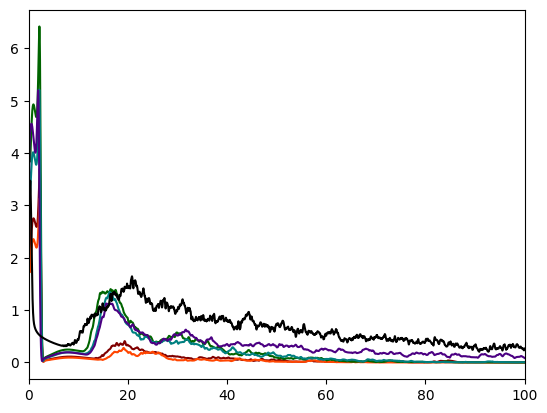

In [45]:
for stim_type in stim_types:
    plt.plot(_t, mean_absolute_errors[stim_type], color=colors[stim_type])

plt.xlim(0,100)

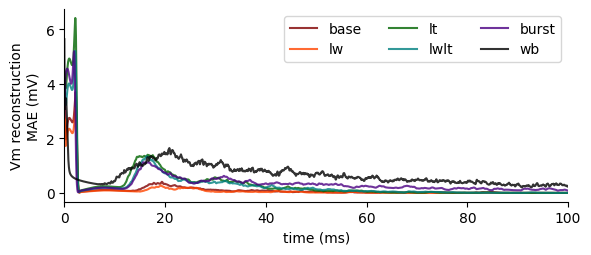

In [51]:
figures_dir = '../figures/'
plt.figure(figsize=(6.5,2.5))
for stim_type in stim_types:
    
    plt.plot(_t, mean_absolute_errors[stim_type], c = colors[stim_type], alpha=0.8)
    
plt.ylabel('Vm reconstruction\nMAE (mV)')
plt.xlabel('time (ms)')


plt.legend(stim_types, loc='upper right', ncols=3)
plt.xlim(0,100)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

savefig = True
if savefig:
    plt.savefig(f'{figures_dir}reconstruction_errors.svg', format='svg')
    #plt.savefig(f'{figures_dir}reconstruction_errors.png', format='png', dpi=300)

plt.show()